# Inference plots - Pairwise scatterplots with KDE

This example builds on the [adaptive covariance MCMC example](https://github.com/pints-team/pints/blob/master/examples/inference-adaptive-covariance-mcmc.ipynb), and shows you a different way to plot the results.
The plot shown here is similar to the [pairwise scatterplots example](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-pairwise-scatterplots.ipynb), but instead of using histogram plots, we use [kernel density estimation (KDE)](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.gaussian_kde.html) to represent the pairwise probability distributions of each parameter.

Inference plots:
* [Predicted time series](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-predicted-time-series.ipynb)
* [Trace plots](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-trace-plots.ipynb)
* [Autocorrelation](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-autocorrelation.ipynb)
* [Pairwise scatterplots](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-pairwise-scatterplots.ipynb)
* __Pairwise scatterplots with KDE__

## Setting up an MCMC routine

See the adaptive covariance MCMC example for details.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 50
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
prior = pints.UniformPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a Bayesian log-likelihood (prior * likelihood)
log_likelihood = pints.LogPosterior(prior, log_likelihood)

# Run an adaptive mcmc routine
x0 = real_parameters * 1.2
mcmc = pints.AdaptiveCovarianceMCMC(log_likelihood, x0)
mcmc.set_verbose(False)

## Plotting one variable: histogram + KDE

We now run the MCMC routine and plot the histogram for a single parameter. In addition, we can use SciPy's [Kernel-Density Estimation (KDE) method](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.gaussian_kde.html) to obtain a smooth estimate of the probability distribution.

In [2]:
print('Running...')
chain = mcmc.run()
print('Done!')

Running...
Done!


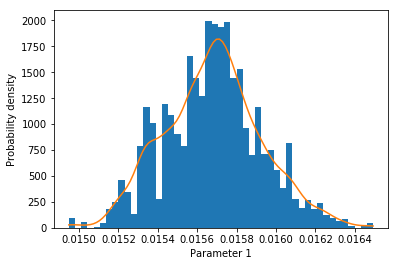

In [3]:
def plot_kde_1d(x, ax):
    """ Creates a 1d histogram and an estimate of the PDF using KDE. """
    xmin = np.min(x)
    xmax = np.max(x)
    x1 = np.linspace(xmin, xmax, 100)
    x2 = np.linspace(xmin, xmax, 50)
    kernel = stats.gaussian_kde(x)
    f = kernel(x1)
    hist = ax.hist(x, bins=x2, normed=True)
    ax.plot(x1, f)

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Parameter 1')
ax.set_ylabel('Probability density')
plot_kde_1d(chain[:, 0], ax)
plt.show()

## Plotting two variables with KDE

We can use KDE again to get very nice plots of 2d distributions.

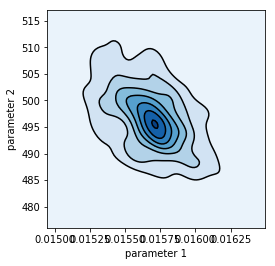

In [4]:
def plot_kde_2d(x, y, ax):
    # Get minimum and maximum values
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    
    # Plot values
    values = np.vstack([x, y])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.imshow(np.rot90(values), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])

    # Create grid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    # Get kernel density estimate and plot contours
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    ax.contourf(xx, yy, f, cmap='Blues')
    ax.contour(xx, yy, f, colors='k')
    
    # Fix aspect ratio, see: https://stackoverflow.com/questions/7965743
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))   

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('parameter 1')
ax.set_ylabel('parameter 2')
plot_kde_2d(chain[:,0], chain[:,1], ax)
plt.show()

## A matrix of scatterplots with KDE

Using these functions, we can now create a matrix of scatterplots with KDE.

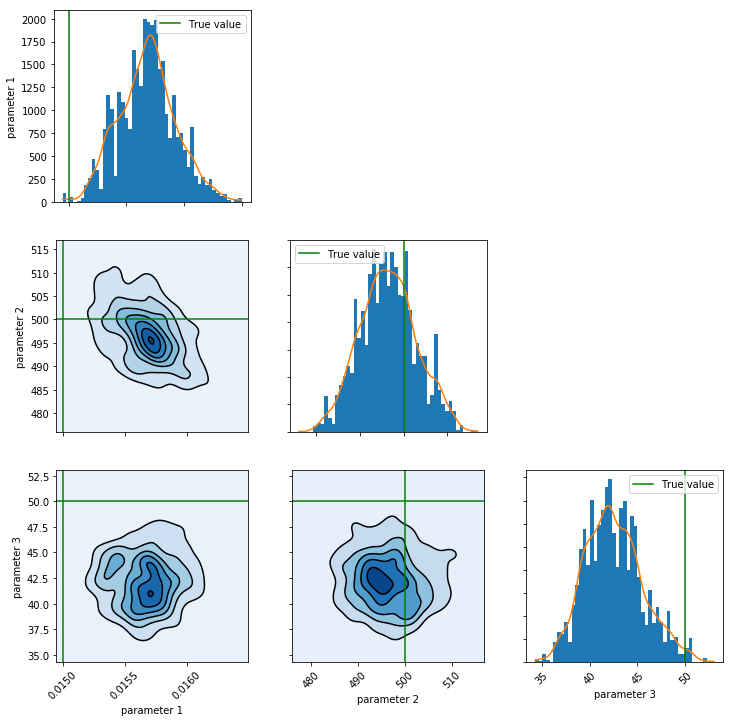

In [5]:
n_param = log_likelihood.dimension()
fig_size = (12, 12)

fig, axes = plt.subplots(n_param, n_param, figsize=fig_size)
for i in range(n_param):
    for j in range(n_param):
        
        # Create subplot
        if i == j:
            # Plot the diagonal
            plot_kde_1d(chain[:,i], ax=axes[i,j])
            axes[i,j].axvline(real_parameters[i], c='g', label='True value')
            axes[i,j].legend()
        elif i < j:
            # Upper triangle: No plot
            axes[i, j].axis('off')
        else:
            # Lower triangle: Pairwise plot
            plot_kde_2d(chain[:,j], chain[:,i], ax=axes[i,j])
            axes[i,j].axhline(real_parameters[i], c='g')
            axes[i,j].axvline(real_parameters[j], c='g')
        
        # Adjust the tick labels
        if i < n_param-1:
            # Only show x tick labels for the last row
            axes[i,j].set_xticklabels([])
        else:
            # Rotation the x tick labels to fit in the plot
            for tl in axes[i,j].get_xticklabels():
                tl.set_rotation(45)
        if j > 0:
            # Only show y tick labels for the first column
            axes[i, j].set_yticklabels([])

    # Add labels to the subplots at the edges
    axes[i,0].set_ylabel('parameter %d'%(i+1))
    axes[-1,i].set_xlabel('parameter %d'%(i+1))

plt.show()